In [6]:
import pandas as pd
import numpy as np

# Load the dataset
df = pd.read_csv('/content/water_dataX.csv', encoding = 'latin-1')

# Rename columns for uniformity
df.rename(columns={
    'Temp': 'Temperature',
    'D.O. (mg/l)': 'DO',
    'PH': 'PH',
    'CONDUCTIVITY (µmhos/cm)': 'Conductivity',
    'B.O.D. (mg/l)': 'BOD',
    'NITRATENAN N+ NITRITENANN (mg/l)': 'Nitrate',
    'FECAL COLIFORM (MPN/100ml)': 'Fecal_Coliform',
    'TOTAL COLIFORM (MPN/100ml)Mean': 'Total_Coliform'
}, inplace=True)

# Convert to numeric and handle missing values
cols = ['Temperature', 'DO', 'PH', 'Conductivity', 'BOD', 'Nitrate', 'Fecal_Coliform', 'Total_Coliform']
df[cols] = df[cols].apply(pd.to_numeric, errors='coerce')
df[cols] = df[cols].fillna(df[cols].mean())  # Impute missing values

# Step 1: Calculate Sub-Indices (Simplified WQI Method)

# Ideal values for water quality (for sub-index calculations)
ideal_DO = 7.0
ideal_PH = 7.0
ideal_BOD = 1.0

# Normalize key parameters (0–100 scale based on empirical formulas)
df['DO_si'] = df['DO'] * (100 / ideal_DO)
df['PH_si'] = (100 / 7.0) * df['PH']
df['BOD_si'] = 100 - (df['BOD'] * 5)

# Clip unrealistic values
df['DO_si'] = df['DO_si'].clip(0, 100)
df['PH_si'] = df['PH_si'].clip(0, 100)
df['BOD_si'] = df['BOD_si'].clip(0, 100)

# Step 2: Final WQI Score
df['WQI'] = (df['DO_si'] * 0.3) + (df['PH_si'] * 0.2) + (df['BOD_si'] * 0.5)

# Step 3: Label Based on WQI
def label_wqi(wqi):
    if wqi >= 80:
        return 'Good'
    elif wqi >= 50:
        return 'Moderate'
    else:
        return 'Poor'

df['WQI_Label'] = df['WQI'].apply(label_wqi)

# Preview the results
print(df[['WQI', 'WQI_Label']])

# Optional: Save output
# df.to_csv('/content/water_dataX.csv', index=False)

            WQI WQI_Label
0     81.364164      Good
1     89.428571      Good
2     92.464286      Good
3     85.071429      Good
4     90.107143      Good
...         ...       ...
1986  93.250000      Good
1987  93.500000      Good
1988  97.000000      Good
1989  96.750000      Good
1990  97.250000      Good

[1991 rows x 2 columns]


            WQI WQI_Label
0     81.364164      Good
1     89.428571      Good
2     92.464286      Good
3     85.071429      Good
4     90.107143      Good
...         ...       ...
1986  93.250000      Good
1987  93.500000      Good
1988  97.000000      Good
1989  96.750000      Good
1990  97.250000      Good

[1991 rows x 2 columns]

====== Logistic Regression ======
Accuracy: 0.9573934837092731
F1 Score: 0.9562015689635626
Classification Report:
               precision    recall  f1-score   support

        Good       0.97      0.99      0.98       336
    Moderate       0.77      0.71      0.74        34
        Poor       0.96      0.86      0.91        29

    accuracy                           0.96       399
   macro avg       0.90      0.85      0.88       399
weighted avg       0.96      0.96      0.96       399

Confusion Matrix:
 [[333   3   0]
 [  9  24   1]
 [  0   4  25]]

====== Decision Tree ======
Accuracy: 0.9849624060150376
F1 Score: 0.9848426233897178
Classificatio

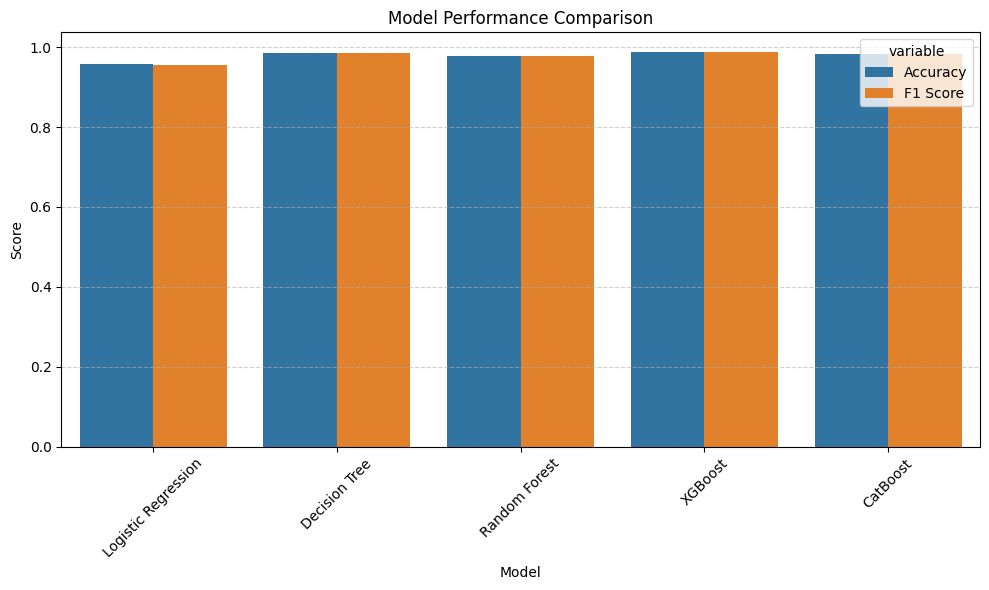

In [8]:
!pip install xgboost catboost

# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
import warnings
warnings.filterwarnings("ignore")

# Step 1: Load and Clean Data
df = pd.read_csv('/content/water_dataX.csv', encoding='latin-1')

# Rename relevant columns
df.rename(columns={
    'Temp': 'Temperature',
    'D.O. (mg/l)': 'DO',
    'PH': 'PH',
    'CONDUCTIVITY (µmhos/cm)': 'Conductivity',
    'B.O.D. (mg/l)': 'BOD',
    'NITRATENAN N+ NITRITENANN (mg/l)': 'Nitrate',
    'FECAL COLIFORM (MPN/100ml)': 'Fecal_Coliform',
    'TOTAL COLIFORM (MPN/100ml)Mean': 'Total_Coliform'
}, inplace=True)

# Keep only numeric columns needed
cols = ['Temperature', 'DO', 'PH', 'Conductivity', 'BOD', 'Nitrate', 'Fecal_Coliform', 'Total_Coliform']
df[cols] = df[cols].apply(pd.to_numeric, errors='coerce')

# Impute missing values with mean
imputer = SimpleImputer(strategy='mean')
df[cols] = imputer.fit_transform(df[cols])

# Step 2: Calculate WQI and Labels
# Sub-index calculations
df['DO_si'] = df['DO'] * (100 / 7.0)
df['PH_si'] = df['PH'] * (100 / 7.0)
df['BOD_si'] = 100 - (df['BOD'] * 5)

# Clip to realistic range
df['DO_si'] = df['DO_si'].clip(0, 100)
df['PH_si'] = df['PH_si'].clip(0, 100)
df['BOD_si'] = df['BOD_si'].clip(0, 100)

# Final WQI Score (Weighted)
df['WQI'] = (df['DO_si'] * 0.3) + (df['PH_si'] * 0.2) + (df['BOD_si'] * 0.5)

# WQI Class Labels
def label_wqi(wqi):
    if wqi >= 80:
        return 'Good'
    elif wqi >= 50:
        return 'Moderate'
    else:
        return 'Poor'

df['WQI_Label'] = df['WQI'].apply(label_wqi)

# Preview the results
print(df[['WQI', 'WQI_Label']])

# Step 3: Prepare Data for ML
X = df[cols]  # features
y = df['WQI_Label']  # labels

# Encode labels (Good=0, Moderate=1, Poor=2)
label_map = {'Good': 0, 'Moderate': 1, 'Poor': 2}
y_encoded = y.map(label_map)

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42)

# Step 4: Train & Evaluate Models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(n_estimators=100),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'),
    'CatBoost': CatBoostClassifier(verbose=0)
}

# Store results
results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    acc = accuracy_score(y_test, preds)
    f1 = f1_score(y_test, preds, average='weighted')
    print(f"\n====== {name} ======")
    print("Accuracy:", acc)
    print("F1 Score:", f1)
    print("Classification Report:\n", classification_report(y_test, preds, target_names=label_map.keys()))
    print("Confusion Matrix:\n", confusion_matrix(y_test, preds))
    results.append((name, acc, f1))

# Step 5: Plot Model Comparison
perf_df = pd.DataFrame(results, columns=['Model', 'Accuracy', 'F1 Score'])
plt.figure(figsize=(10, 6))
sns.barplot(data=perf_df.melt(id_vars='Model'), x='Model', y='value', hue='variable')
plt.title('Model Performance Comparison')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# Optional: Save results with WQI and labels
# df.to_csv('/content/water_dataX_with_WQI_and_labels.csv', index=False)

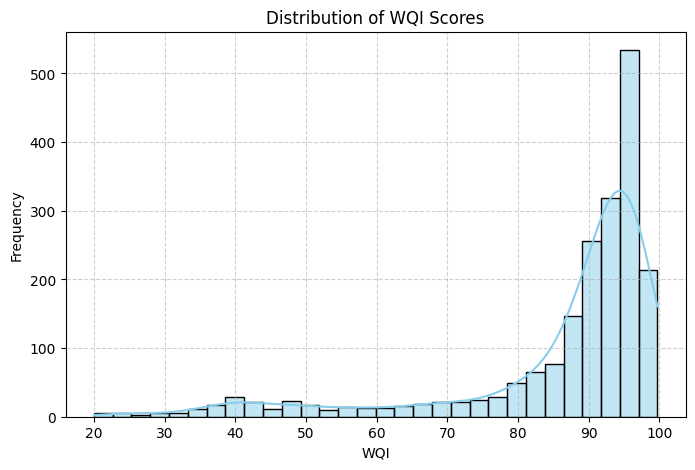

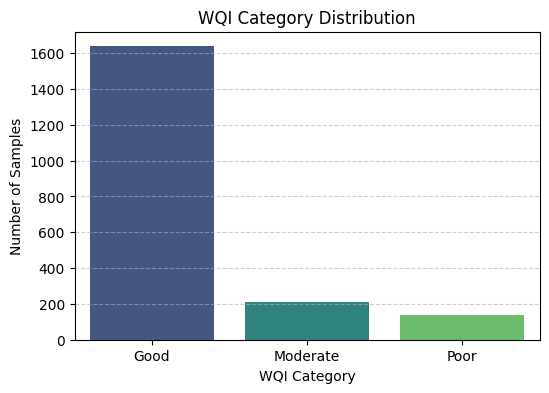

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Histogram of WQI Scores
plt.figure(figsize=(8, 5))
sns.histplot(df['WQI'], bins=30, kde=True, color='skyblue')
plt.title('Distribution of WQI Scores')
plt.xlabel('WQI')
plt.ylabel('Frequency')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# Count Plot of WQI Categories (Labels)
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='WQI_Label', palette='viridis', order=['Good', 'Moderate', 'Poor'])
plt.title('WQI Category Distribution')
plt.xlabel('WQI Category')
plt.ylabel('Number of Samples')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()